In [1]:
%autosave 180
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML,clear_output
# display(HTML("<style>.container { width:100% !important; }</style>"))

Autosaving every 180 seconds


In [2]:
import numpy as np
import pylab as plt
import sys

In [3]:
sys.path.append(r'C:\Users\loginovgn\PycharmProjects')

# Define  survay

(-1100.0, 1100.0, -1100.0, 1100.0)

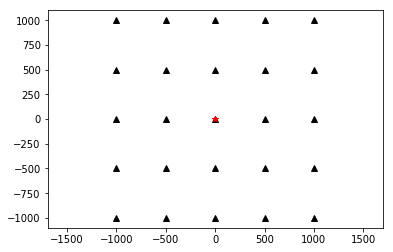

In [4]:
sou= np.array([[0, 0, 30]])

x, y, = np.meshgrid(
    np.linspace(-1000, 1000, 5),
    np.linspace(-1000, 1000, 5)
)
rec = np.array([x.ravel(), y.ravel(), np.zeros(len(x.ravel()))]).T

plt.plot(rec[:,0], rec[:,1], '^k')
plt.plot(sou[:,0], sou[:,1], '*r')
plt.axis('equal')

# Define media

In [5]:
rho = 1000
vs = 2000
vp = 3500

# Assume homogenous isotropic media and calculate travel times

In [6]:
distance = np.sqrt((rec - sou) ** 2).sum(axis=1, keepdims=True)
tau_p = distance / vp
tau_s = distance / vs

# Model seismogram

In [7]:
from seislab.src import seislet

In [8]:
dt = .001
ns = np.int32( (tau_s.max() * 4 / 3) / dt)
traces = seislet.seismic_signal(signal='berlage', tau=tau_p, dt=dt, ns=ns, f=50)

# Plot seismogram

In [9]:
from seislab.src import plot_seismic 

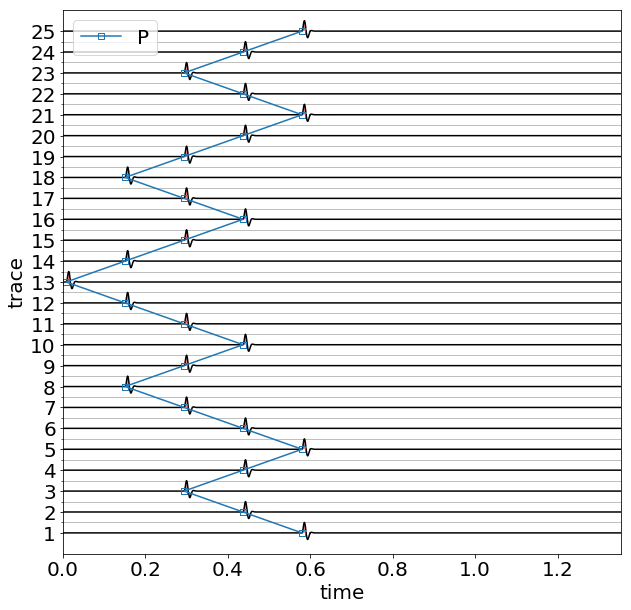

In [10]:
plot_seismic.plot_traces(
    traces, 
    dt=dt, 
    fill_positive='r', 
    trace_color='k',
    picks={'P': tau_p/dt},
    picks_curve=True,
    font_size=20
)

# Check spectra

In [11]:
from seislab.src import dsp

amp.shape (25, 677)


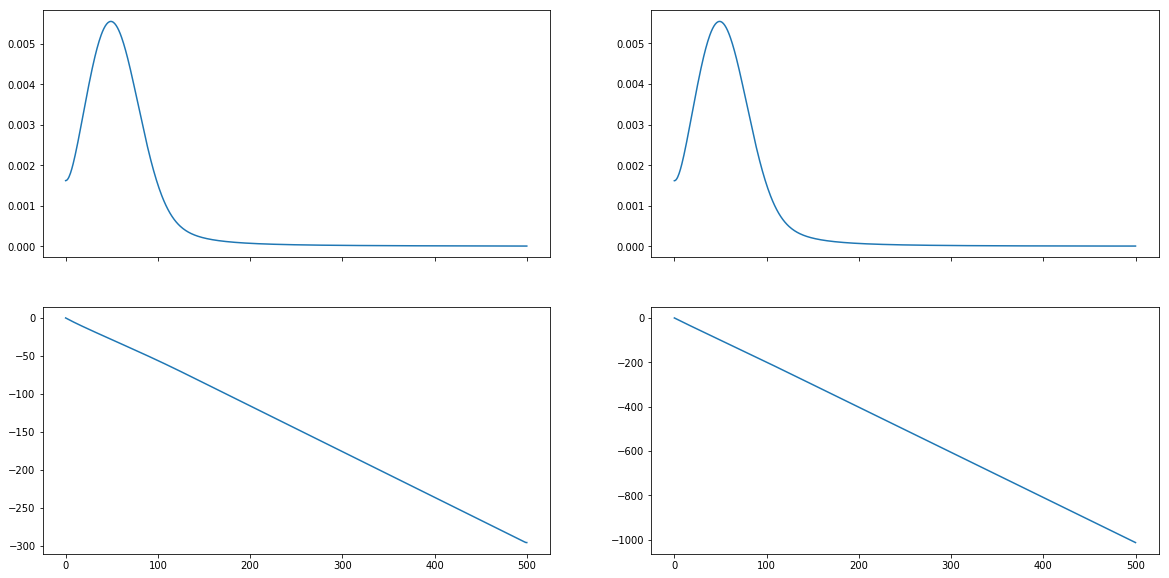

In [12]:
amp, phase = dsp.amplitude_n_phase_spectrum(traces, axis=1)
print('amp.shape', amp.shape)
frequency = dsp.f_range(dt, traces.shape[1])

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, squeeze=False, figsize=(20,10))
axs = axs.ravel()
axs[0].plot(frequency, amp[0])
axs[1].plot(frequency, amp.mean(axis=0))
axs[2].plot(frequency, phase[0])
axs[3].plot(frequency, phase.mean(axis=0))


# Add S-wave and frequency variations

traces.shape (25, 1353)


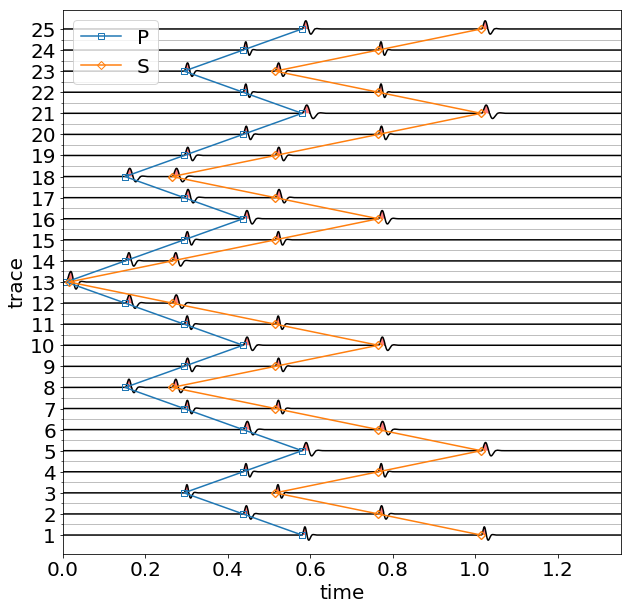

In [13]:
dt = .001
ns = np.int32( (tau_s.max() * 4 / 3) / dt)
fp = np.random.uniform(low=25, high=45, size=(len(rec),1))
fs = np.random.uniform(low=15, high=25, size=(len(rec),1))

traces_p = seislet.seismic_signal(signal='berlage', tau=tau_p, dt=dt, ns=ns, f=fp)
traces_s = seislet.seismic_signal(signal='berlage', tau=tau_s, dt=dt, ns=ns, f=fp)
traces = traces_p + traces_s
print('traces.shape', traces.shape)

plot_seismic.plot_traces(
    traces, 
    dt=dt, 
    fill_positive='r', 
    trace_color='k',
    picks={'P': tau_p/dt, "S":tau_s/dt},
    picks_curve=True,
    font_size=20
)

amp.shape (25, 677)


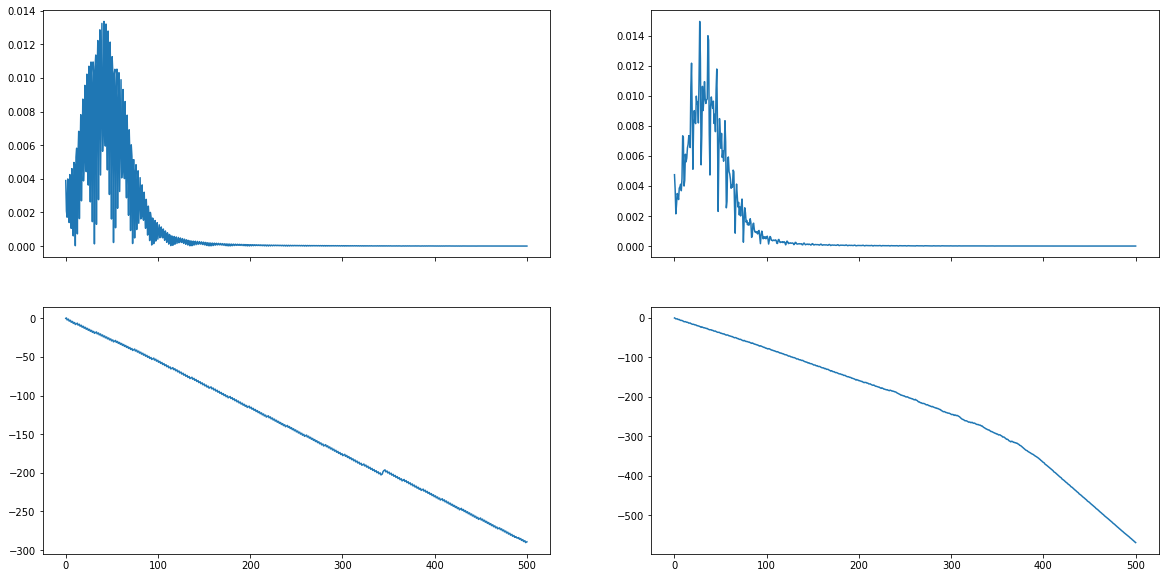

In [14]:
amp, phase = dsp.amplitude_n_phase_spectrum(traces, axis=1)
print('amp.shape', amp.shape)
frequency = dsp.f_range(dt, traces.shape[1])

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, squeeze=False, figsize=(20,10))
axs = axs.ravel()
axs[0].plot(frequency, amp[0])
axs[1].plot(frequency, amp.mean(axis=0))
axs[2].plot(frequency, phase[0])
axs[3].plot(frequency, phase.mean(axis=0))

# Add random noise and band_pass_filter

In [15]:
from seislab.src import dsp

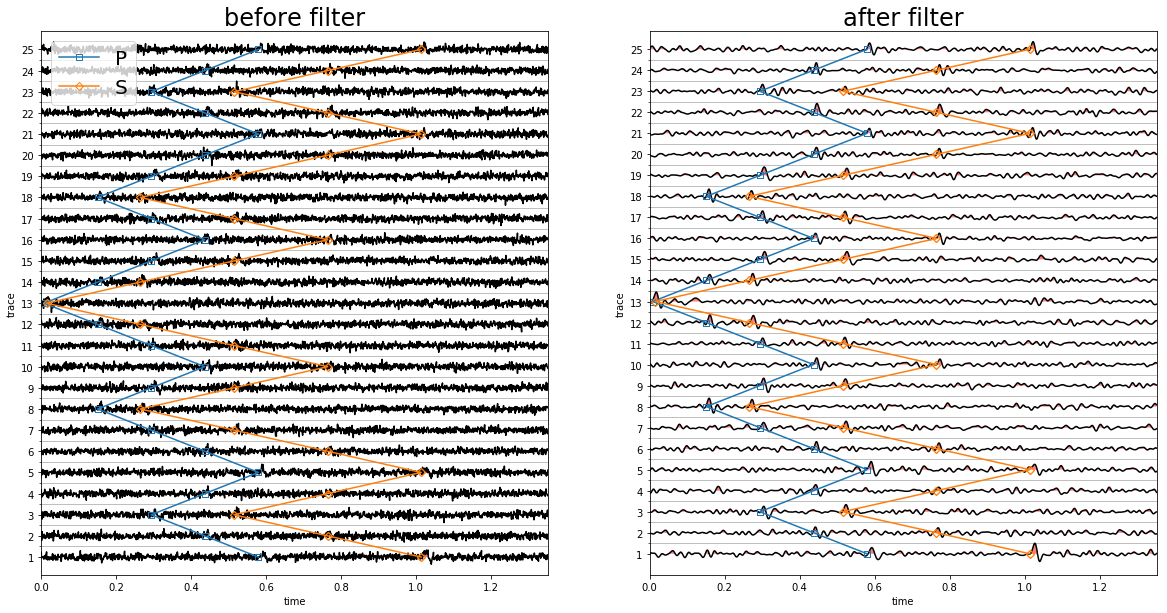

In [16]:
dt = .001
ns = np.int32( (tau_s.max() * 4 / 3) / dt)
fp = np.random.uniform(low=25, high=45, size=(len(rec),1))
fs = np.random.uniform(low=15, high=25, size=(len(rec),1))

traces_p = seislet.seismic_signal(signal='berlage', tau=tau_p, dt=dt, ns=ns, f=fp)
traces_s = seislet.seismic_signal(signal='berlage', tau=tau_s, dt=dt, ns=ns, f=fp)
traces = traces_p + traces_s

traces += np.random.randn(*traces.shape) *.5

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10), facecolor='w', squeeze=False)
axs = axs.ravel()

plot_seismic.plot_traces(
    traces, 
    dt=dt, 
    fill_positive='r', 
    trace_color='k',
    picks={'P': tau_p/dt, "S":tau_s/dt},
    picks_curve=True,
    font_size=20,
    title='before filter',
    ax=axs[0],
)

traces = dsp.apply_band_pass(traces, dt, [0,10, 50, 80])
plot_seismic.plot_traces(
    traces, 
    dt=dt, 
    fill_positive='r', 
    trace_color='k',
    picks={'P': tau_p/dt, "S":tau_s/dt},
    picks_curve=True,
    font_size=20,
    title='after filter',
    ax=axs[1],
    picks_legend=False,
)

# Define mechanism 

In [17]:
from seislab.src import smti

MomentTensor: 
 [[  0.00000000e+00              inf  -4.76837158e-07]
 [             inf   0.00000000e+00   0.00000000e+00]
 [ -4.76837158e-07   0.00000000e+00   0.00000000e+00]]


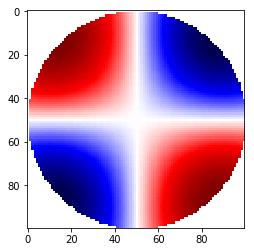

In [18]:
shear_intense = 1
open_intense = 0
surface = 1
strike, dip, rake = 0, 90, 0

m = smti.create_general_moment(strike, dip, rake, ds=shear_intense, dn=open_intense, a=surface, rho=rho, vs=vs, vp=vp)
u,_,_,_ = smti.focal_projection(m)
plt.imshow(u, cmap='seismic')
print('MomentTensor: \n',np.float16(m))

In [19]:
from seislab.src import plot_maps

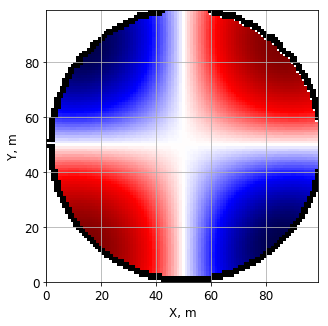

In [73]:
plot_maps.plot_map(u, add_bound=True, interpolation='nearest')

# Get radiation operator (isotropic)

(n, m) - number of receivers * 3 (no. of components), moment tensor components 

In [87]:
g_p, g_s = smti.radiation_operator(sou, rec)
g_p.shape

(75, 9)

# Calculate amplitude

In [88]:
u_p, u_s = smti.calculate_wave_amplitude(sou, rec, m.ravel(), vp, vs, rho)
u_p.shape

(75,)

In [89]:
u_p, u_s = smti.calculate_wave_amplitude(sou, rec, m.ravel(), vs, vs, rho, reshape=True)
u_p.shape

(25, 3)

# Plot amplitude

In [18]:
from seislab.src import plot_maps

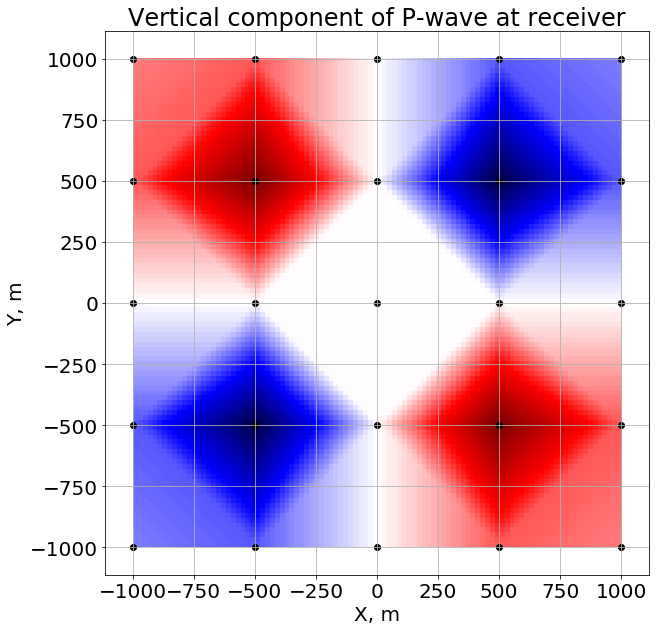

In [19]:
plot_maps.plot_map(
    rec[:,0], 
    rec[:,1], 
    u_p[:,2],
    font_size=20,
    fig_height=10,
    fig_width=10,
    interp_method='linear', 
    title='Vertical component of P-wave at receiver', 
    add_xy=True,
    add_bound=False
)

# create synthetic data

In [99]:
dt = .001
ns = np.int32( (tau_s.max() * 4 / 3) / dt)
fp = np.random.uniform(low=25, high=45, size=(len(rec),1))
fs = np.random.uniform(low=15, high=25, size=(len(rec),1))

traces_p = seislet.seismic_signal(signal='berlage', tau=tau_p, dt=dt, ns=ns, f=fp)
traces_s = seislet.seismic_signal(signal='berlage', tau=tau_s, dt=dt, ns=ns, f=fp)

traces = np.einsum('rt, rc ->rtc', traces_p, u_p) + np.einsum('rt, rc ->rtc', traces_s, u_s)

traces /= np.nanmax(np.abs(traces))

traces += np.random.randn(*traces.shape) *.05

traces = dsp.apply_band_pass(traces, dt, [0,10, 50, 80])


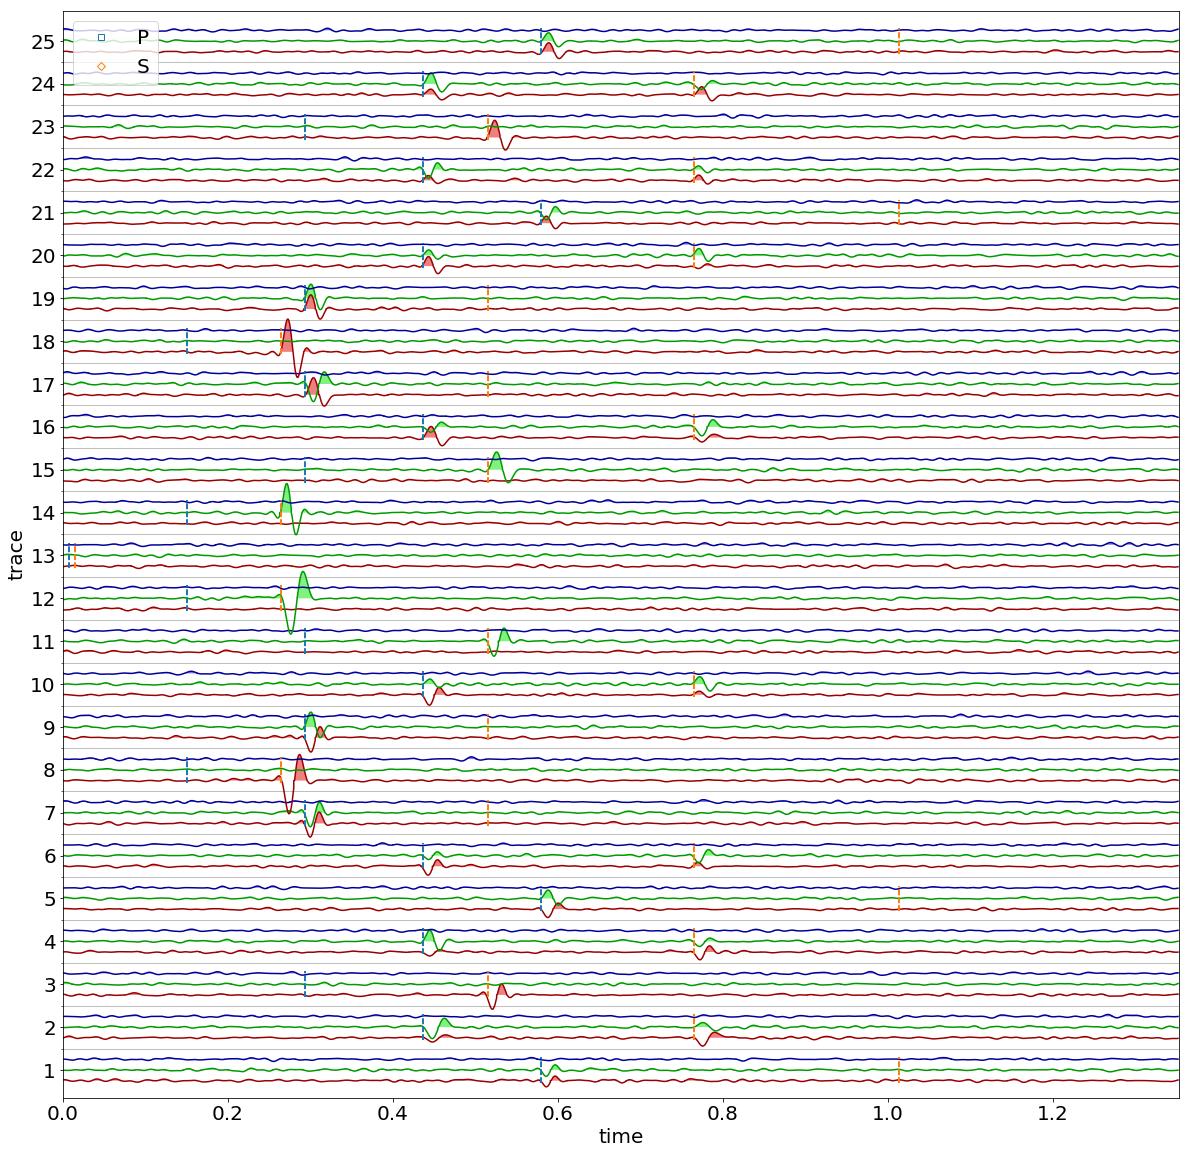

In [100]:
plot_seismic.plot_traces(
    traces, 
    dt=dt, 
    picks={'P': tau_p/dt, "S":tau_s/dt},
    picks_curve=False,
    fig_height=20, 
    fig_width=20,
    dist_for_3c=1,
    fill_positive=True,
    gain=5,
)